In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [3]:
df = pd.read_excel("Temperature in Sao Paulo.xlsx",index_col='Date',parse_dates=True, sheet_name="DJIA")


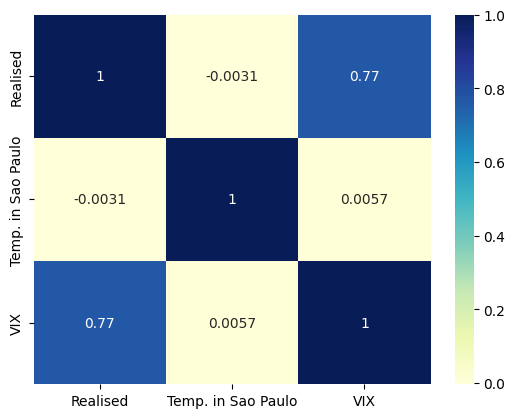

In [4]:
import seaborn as sb
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [6]:
df = pd.read_excel("Temperature in Sao Paulo (NBEATSx).xlsx",index_col='Date',parse_dates=True, sheet_name="DJIA")

In [7]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

Epoch: 200 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001

# H=1 Forecasts

In [8]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [9]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [10]:
for i in range(15):
  model = NBEATSx(h=1, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=150,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 11215486


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101814014


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 123745581


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60164625


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 84681365


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 19143311


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 24654034


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101549645


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 28455227


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 76375055


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 120443325


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 43237474


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 127832171


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 94273266


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 38283787


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [11]:
Accuracy

[67.31447464852374,
 68.54934036214433,
 67.6048755177197,
 67.60514429501717,
 65.72550416194017,
 68.36506513349914,
 68.85231322526725,
 68.64682428457205,
 68.10573535403196,
 68.00378057646122,
 66.63216435014108,
 67.9544148124262,
 68.4906516971066,
 68.69452751192667,
 68.04182405781106]

In [12]:
RMSE

[0.0022089143066290977,
 0.002182963937932834,
 0.0021838655261872137,
 0.0021471019255466903,
 0.0021888824928394334,
 0.0021553308451820363,
 0.002112267753130971,
 0.0021741164188572013,
 0.002162801561937747,
 0.0021614842398532488,
 0.002192418734493664,
 0.002170383210564048,
 0.002169346154089491,
 0.0021628619498008546,
 0.0021636460191063224]

In [13]:
Quasilikelihood

[0.08197377071967435,
 0.08365029729468455,
 0.08071168732704197,
 0.07546335798429887,
 0.07586577319161573,
 0.07997627821635563,
 0.07530742907423003,
 0.0827781476826967,
 0.08038563747706716,
 0.0789784388589521,
 0.07879052752447925,
 0.07972713969849322,
 0.08245672523406054,
 0.08135372892416101,
 0.08046040344705631]

Text(0, 0.5, 'DJIA Realized Volatility')

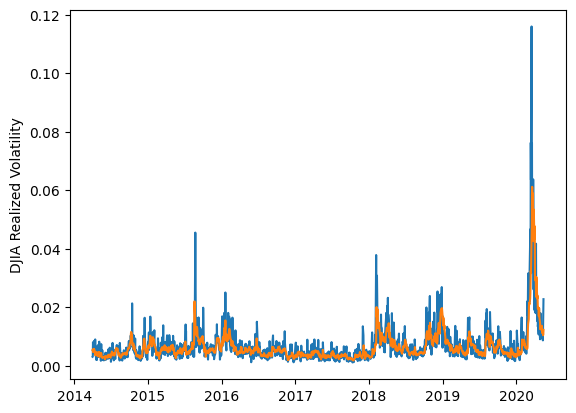

In [14]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=3 Forecasts

In [15]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [16]:
for i in range(15):
  model = NBEATSx(h=3, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=150,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-1,step_size=3)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 70203775


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 51667640


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 914244


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 103253413


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 102299756


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 72214175


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 70566592


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 112674062


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 89940886


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 116089149


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 45438350


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90438779


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 81956490


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34627555


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 94875311


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [17]:
RMSE

[0.002295436421016136,
 0.002282928281284984,
 0.0023147481322135315,
 0.0022957124043594124,
 0.002287436623684687,
 0.0022913790148801723,
 0.0023093366261569648,
 0.0023030837763773552,
 0.00229206569050211,
 0.0023205262355380455,
 0.0022808392997693476,
 0.0023286869920736736,
 0.0022976904110075225,
 0.0022797330100474654,
 0.002282856774995703]

In [18]:
Accuracy


[66.44179141027851,
 66.89034333936283,
 65.41856945722395,
 66.63074801852349,
 66.79814596041946,
 66.40554338390294,
 65.89316426185698,
 65.84979162111111,
 66.31702367954529,
 65.19694226395127,
 65.82339264804592,
 66.08799394248622,
 66.15045935671593,
 66.81529855293196,
 66.32131346020402]

In [19]:
Quasilikelihood

[0.0887954556399576,
 0.09058462146177468,
 0.08736288117183384,
 0.0896783514866161,
 0.08831521886219434,
 0.08831602384635252,
 0.08863596495096665,
 0.086686227724592,
 0.08898574103531533,
 0.08754832640073296,
 0.08533948949641011,
 0.09233285359432256,
 0.08808219987236016,
 0.08961945929066482,
 0.08692916280004652]

Text(0, 0.5, 'DJIA Realized Volatility')

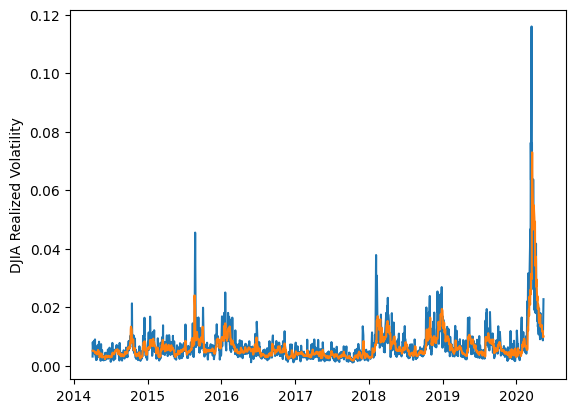

In [20]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=5 Forecasts

In [21]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [22]:
test_length%5

2

In [23]:
for i in range(15):
  model = NBEATSx(h=5, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=150,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-2,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 89764509


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27577502


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 105702853


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 86666831


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27275040


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 125364093


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60654339


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90951270


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87218485


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 41550359


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 107351015


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 50384804


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 37232032


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77128635


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83352441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [24]:
RMSE

[0.0024576373796654344,
 0.002456950705064986,
 0.0024707043253310596,
 0.00246134154946819,
 0.0024634443959148304,
 0.0024737636443526983,
 0.002426769787589009,
 0.002477889874611413,
 0.0024683802508467657,
 0.0024598337688276,
 0.0024472175706956186,
 0.0024603043904704155,
 0.0024531373357894446,
 0.0024473939120266772,
 0.0024577577673098776]

In [25]:
Accuracy

[64.14787826484655,
 64.57138780002911,
 64.47068454972883,
 64.8792983193782,
 63.79699584124586,
 64.02512664866924,
 64.91760522459971,
 63.98319043357568,
 64.3591155792653,
 65.07027091326688,
 64.92429417101351,
 64.73469997671934,
 64.35218793818002,
 64.12078345287986,
 65.09003464660958]

In [26]:
Quasilikelihood

[0.10673652894695124,
 0.11099932879509095,
 0.11115708993875516,
 0.11221786036985013,
 0.10677977273951286,
 0.10959661341666012,
 0.10885248214030928,
 0.11028566796377594,
 0.11088582976987757,
 0.11332214010582417,
 0.11243660742520276,
 0.11290125850539064,
 0.10939060612310121,
 0.10785404093468791,
 0.11397862659624393]

Text(0, 0.5, 'DJIA Realized Volatility')

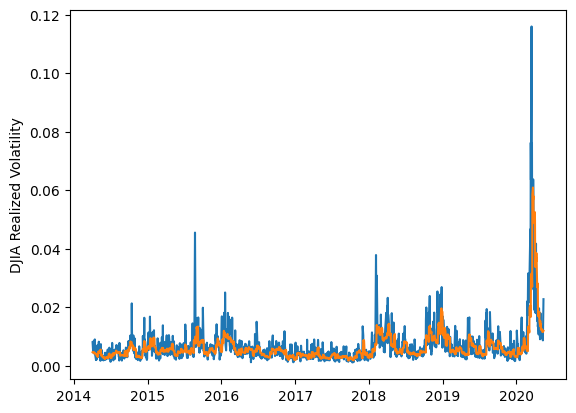

In [27]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=10 Forecasts

In [28]:
test_length%10

7

In [29]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [30]:
for i in range(15):
  model = NBEATSx(h=10, input_size=12,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=150,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-7,step_size=10)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 28453412


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60335794


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91578117


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 56600366


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 129133510


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 127188474


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 75884835


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 61635777


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 7340019


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 112851124


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20519631


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47593233


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 104418516


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121795457


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 41910240


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [31]:
RMSE

[0.002866272401668267,
 0.002804976498862969,
 0.0028474832346889567,
 0.002850381700193745,
 0.002844581814323823,
 0.0028260741194176702,
 0.0028270725369427545,
 0.0028537391450541125,
 0.0028333719572872225,
 0.0028187953611854273,
 0.0028505418339680793,
 0.0028464308474846945,
 0.00281182223211557,
 0.002877094815172448,
 0.0028496057410695333]

In [32]:
Accuracy

[58.03571286516052,
 59.09448715901674,
 57.96093358106401,
 58.30236312693968,
 57.91080370785902,
 58.49769103311353,
 58.18606050730393,
 57.67340501289129,
 58.681441408839284,
 58.27085145807068,
 58.644763717008615,
 57.881748357055876,
 58.51962737204928,
 57.62676015808914,
 57.28866683899357]

In [33]:
Quasilikelihood

[0.15065753214310199,
 0.15216132901219034,
 0.14892863978294527,
 0.15144295532293156,
 0.14658052039714226,
 0.1504448028696767,
 0.14665665406067804,
 0.14858580346718503,
 0.1502833488786612,
 0.1434510522724036,
 0.15394742332550757,
 0.15119235923852672,
 0.14875089516303008,
 0.1528329061915621,
 0.1431168371506788]

Text(0, 0.5, 'DJIA Realized Volatility')

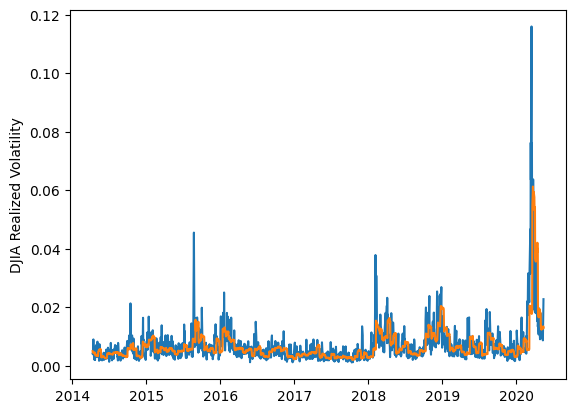

In [34]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")

# H=22 Forecasts

In [35]:
test_length%22

19

In [36]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [37]:
for i in range(15):
  model = NBEATSx(h=22, input_size=12,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=150,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-19,step_size=22)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 40543268


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 49897105


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 128701515


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69355414


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 123532069


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5452453


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 21997483


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83703336


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117383884


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 28811553


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20608440


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80643809


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47484457


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 54308018


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 82711531


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [38]:
RMSE

[0.0035854330543562173,
 0.0037354396135301482,
 0.0035550241478505174,
 0.0036051205043911246,
 0.003640879639618295,
 0.003522145038769767,
 0.0036297450218747748,
 0.003548445318553869,
 0.0035752313497673435,
 0.00356596348321551,
 0.003392304823234822,
 0.003594974876940273,
 0.003519987234912745,
 0.003662117290748361,
 0.0035693496207189254]

In [39]:
Accuracy

[44.22282847309938,
 42.42656863453158,
 44.82968734061473,
 44.728301227256686,
 43.724454198425214,
 45.56590760306845,
 43.64744518848027,
 45.46802013830194,
 44.85301770312714,
 44.922591627090235,
 47.33154287064531,
 44.25169963426695,
 45.34468102517466,
 43.37280234246741,
 44.66575572234374]

In [40]:
Quasilikelihood

[0.20983628600612378,
 0.21879224555726667,
 0.2040388315416515,
 0.22155204085376093,
 0.21096843228364337,
 0.2060639810979521,
 0.21234704609033261,
 0.2226030157308482,
 0.21396296147713995,
 0.21060435877285458,
 0.195800327041437,
 0.21490263722778602,
 0.2099493457176472,
 0.21634327639140918,
 0.2129431482748233]

Text(0, 0.5, 'DJIA Realized Volatility')

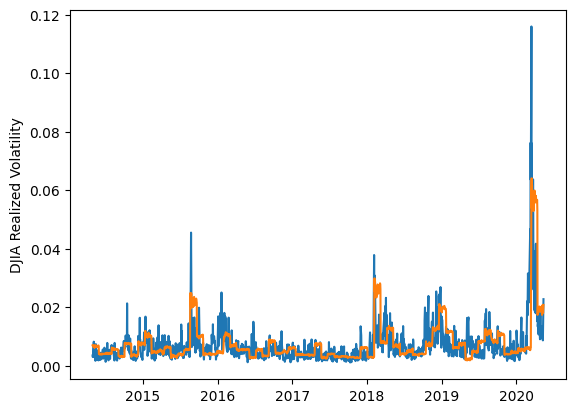

In [41]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("DJIA Realized Volatility")